<a href="https://colab.research.google.com/github/AnthonyJFeola/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# Import.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [0]:
# Load dataset.
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-02-03 23:24:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.07s   

2020-02-03 23:24:29 (263 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [0]:
# Issues used to iterate in below functions and loops.
column_headers_exclude_party = ['handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

In [0]:
# Column headers.
column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

df = pd.read_csv('house-votes-84.data', 
                 header=None, 
                 names=column_headers,
                 na_values="?")
df = df.replace({'y': 1, 'n': 0})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
# Republican subset.
republican_overview = df[df['party'] == 'republican']
republican_overview.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [0]:
# Democrat subset.
democrat_overview = df[df['party'] == 'democrat']
democrat_overview.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [0]:
# Confidence interval function.
def confidence_interval(data, confidence=0.95):
    sample = np.array(data)
    n = len(sample)
    sample_mean, std_err = np.nanmean(sample), stats.sem(sample, nan_policy='omit')
    m_o_e = std_err * stats.t.ppf((1 + confidence) / 2.0, n-1)
    return sample_mean, sample_mean-m_o_e, sample_mean+m_o_e

In [0]:
# Iterative confidence interval function for Republicans.
def confidence_interval_republican_votes(issues):
    for issue in issues:
      print(confidence_interval(republican_overview[issue]))

In [0]:
confidence_interval_republican_votes(column_headers_exclude_party)

(0.18787878787878787, 0.12765970533224502, 0.2480978704253307)
(0.5067567567567568, 0.4253466290971483, 0.5881668844163653)
(0.13414634146341464, 0.08144464211356062, 0.18684804081326867)
(0.9878787878787879, 0.9710089974059941, 1.0047485783515817)
(0.9515151515151515, 0.9184023665939026, 0.9846279364364005)
(0.8975903614457831, 0.8509916088148402, 0.944189114076726)
(0.24074074074074073, 0.17421899109507472, 0.30726249038640674)
(0.15286624203821655, 0.09598406017514066, 0.20974842390129245)
(0.11515151515151516, 0.0659414299566374, 0.1643616003463929)
(0.5575757575757576, 0.48100618332950074, 0.6341453318220145)
(0.1320754716981132, 0.07889768232377367, 0.18525326107245274)
(0.8709677419354839, 0.8176346723451018, 0.924300811525866)
(0.8607594936708861, 0.8062112667860005, 0.9153077205557717)
(0.9813664596273292, 0.9602602590877117, 1.0024726601669465)
(0.08974358974358974, 0.04441997917099207, 0.1350672003161874)
(0.6575342465753424, 0.5797322900481647, 0.7353362031025201)


In [0]:
# Iterative confidence interval function for Democrats.
def confidence_interval_democrat_votes(issues):
    for issue in issues:
      print(confidence_interval(democrat_overview[issue]))

In [0]:
confidence_interval_democrat_votes(column_headers_exclude_party)

(0.6046511627906976, 0.5446023119663105, 0.6647000136150848)
(0.502092050209205, 0.43827946969561743, 0.5659046307227926)
(0.8884615384615384, 0.8499482730976454, 0.9269748038254314)
(0.05405405405405406, 0.026335790101522146, 0.08177231800658596)
(0.21568627450980393, 0.1648740875961387, 0.26649846142346917)
(0.47674418604651164, 0.41540164594648316, 0.5380867261465401)
(0.7722007722007722, 0.7207893083591004, 0.823612236042444)
(0.8288973384030418, 0.7830877180386255, 0.8747069587674581)
(0.7580645161290323, 0.7044128793801164, 0.8117161528779481)
(0.4714828897338403, 0.41076167770876976, 0.5322041017589109)
(0.5058823529411764, 0.4441160407628015, 0.5676486651195514)
(0.14457831325301204, 0.1006095299824307, 0.1885470965235934)
(0.2896825396825397, 0.23330850385252477, 0.34605657551255464)
(0.35019455252918286, 0.29149227281933154, 0.40889683223903417)
(0.6374501992031872, 0.5775862250344871, 0.6973141733718874)
(0.9351351351351351, 0.8993863228167117, 0.9708839474535585)


In [0]:
# Iterative confidence interval plotting function for Republicans.
def plot_confidence_intervals_republican(issues):
  for issue in issues:
    sns.kdeplot(republican_overview[issue].dropna())
    CI = confidence_interval(republican_overview[issue])
    plt.axvline(x=CI[1], color='red');
    plt.axvline(x=CI[2], color='red');
    plt.axvline(x=CI[0], color='k');
    plt.show()

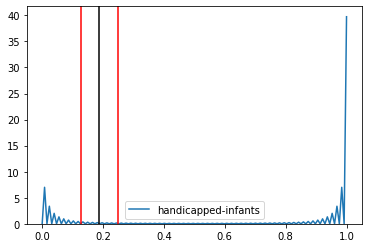

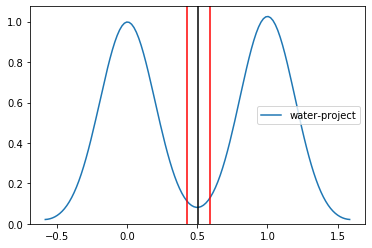

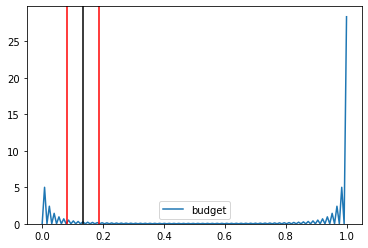

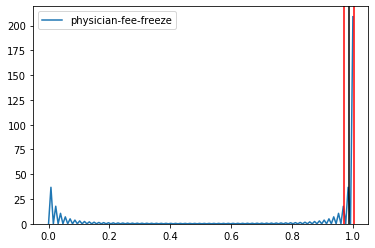

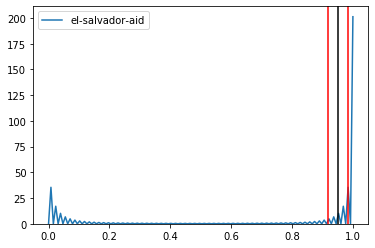

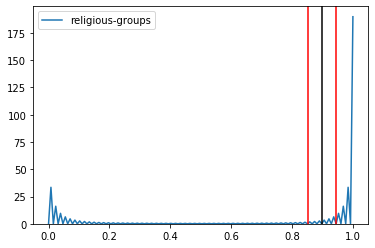

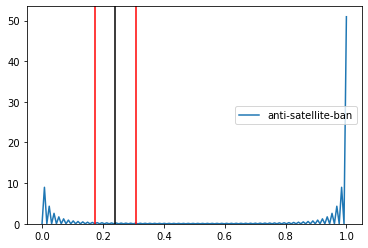

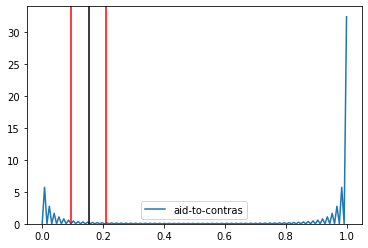

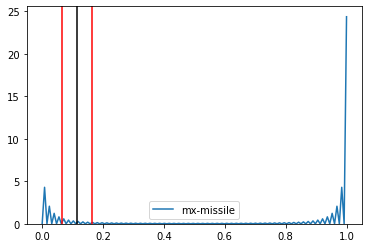

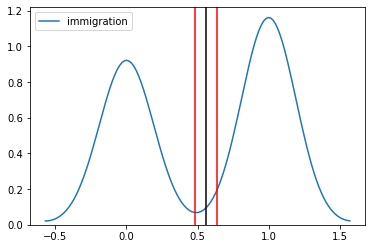

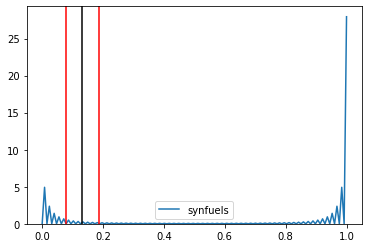

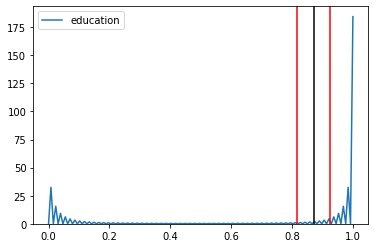

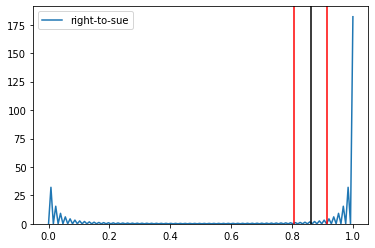

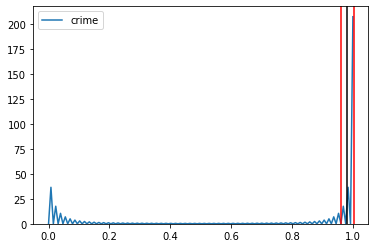

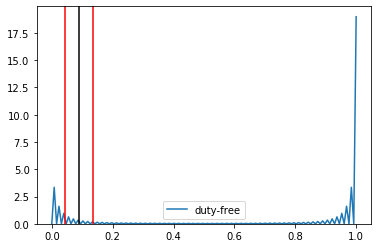

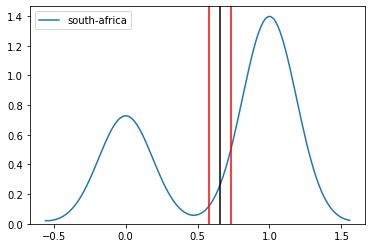

In [0]:
plot_confidence_intervals_republican(column_headers_exclude_party)

In [0]:
# Iterative confidence interval plotting function for Democrats.
def plot_confidence_intervals_democrat(issues):
  for issue in issues:
    sns.kdeplot(democrat_overview[issue].dropna())
    CI = confidence_interval(democrat_overview[issue])
    plt.axvline(x=CI[1], color='red');
    plt.axvline(x=CI[2], color='red');
    plt.axvline(x=CI[0], color='k');
    plt.show()

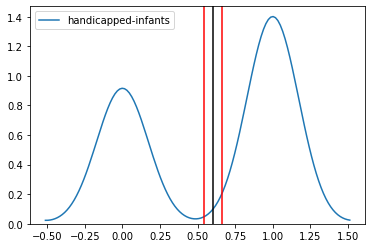

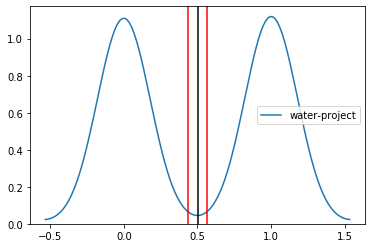

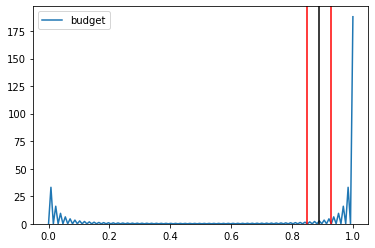

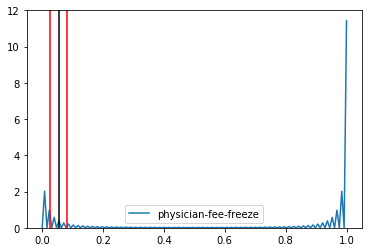

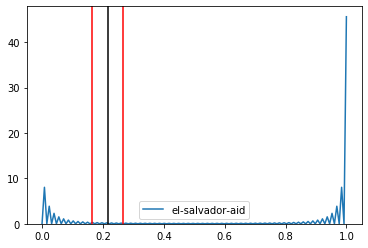

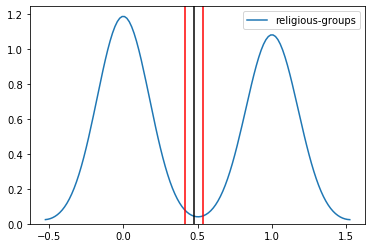

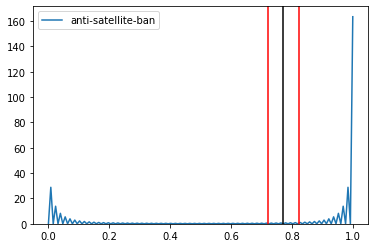

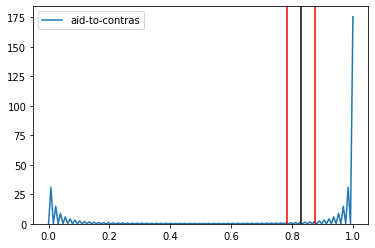

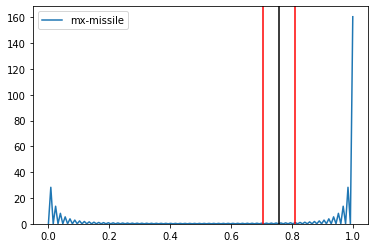

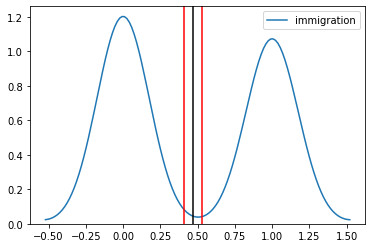

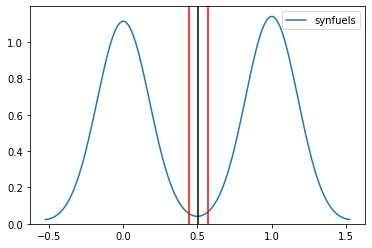

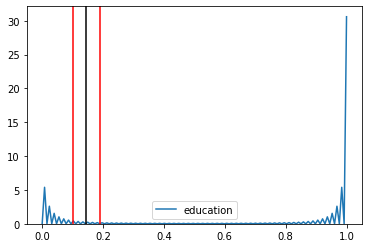

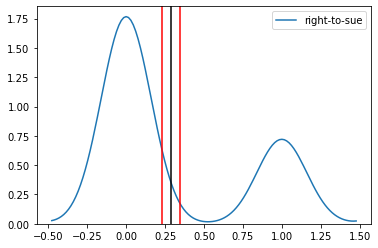

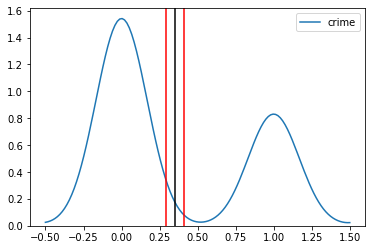

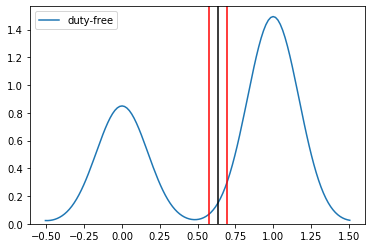

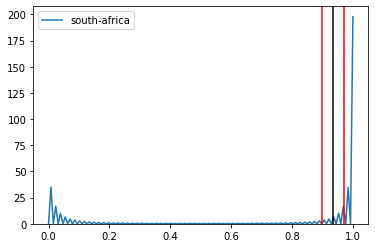

In [0]:
plot_confidence_intervals_democrat(column_headers_exclude_party)

***What do the confidence intervals tell us?*** 

The confidence intervals tell us that our data is extremely polarized. This is evident because capturing votes results in binary data. All but a few of the political issue confidence intervals above actually capture the population mean. Since voting yes or no on a topic is binary, we should expect a population mean of 0.5 for each issue. As outlined by the null hypothesis, half of the representatives will support each issue, whereas the other half will not support each issue (there is no clear favorite). For the majority of the issues above, we will reject the null hypothesis. Only a handful of cases above capture the population mean, and as such, those certain cases will fail to reject the null hypothesis. Furthermore, it is safe to assume that bipartisanship is rare, and both parties will most likely take an opposite stance on political issues.

In [0]:
# Read in dataset.
df_adults = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
df_adults.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
# Create contingency table.
contingency_table = pd.crosstab(df_adults['salary'], df_adults['race'], margins=True)
contingency_table

race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,All
salary,,,,,,
<=50K,275,763,2737,246,20699,24720
>50K,36,276,387,25,7117,7841
All,311,1039,3124,271,27816,32561


In [0]:
# Isolate row sums and column sums.
row_sums = contingency_table.iloc[0:2, 5].values
col_sums = contingency_table.iloc[2, 0:5].values
print(row_sums)
print(col_sums)

[24720  7841]
[  311  1039  3124   271 27816]


In [0]:
# Contingency table total.
total = contingency_table.loc['All','All']
total

32561

In [0]:
# Expected values.
expected = []
for i in range(len(row_sums)):
    expected_row = []
    for column in col_sums:
        expected_val = column*row_sums[i]/total
        expected_row.append(expected_val)
    expected.append(expected_row)  
expected = np.array(expected)
print(expected.shape)  
print(expected)

(2, 5)
[[  236.10822763   788.79886981  2371.71094254   205.74060993
  21117.64135008]
 [   74.89177237   250.20113019   752.28905746    65.25939007
   6698.35864992]]


In [0]:
# Observed values using contingency table.
observed = pd.crosstab(df_adults['salary'], df_adults['race']).values
print(observed.shape)
observed

(2, 5)


array([[  275,   763,  2737,   246, 20699],
       [   36,   276,   387,    25,  7117]])

In [0]:
# Chi-Squared using Numpy.
chi_squared = ((observed - expected)**2/(expected)).sum() 
print(f"Chi-Squared: {chi_squared}")

Chi-Squared: 330.9204310085741


In [0]:
# Calculate degrees of freedom.
dof = (len(row_sums)-1)*(len(col_sums)-1)
print(f"Degrees of Freedom: {dof}")   

Degrees of Freedom: 4


In [0]:
# Chi-Squared using SciPy.
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)
print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 330.9204310085741
P-value: 2.305960610160958e-70
Degrees of Freedom: 4
Expected: 
 [[  236.10822763   788.79886981  2371.71094254   205.74060993
  21117.64135008]
 [   74.89177237   250.20113019   752.28905746    65.25939007
   6698.35864992]]


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)